In this code, we assume the following notation for the Standard Hopfield model:
- N is the size of the patterns;
- M is the number of patterns that we want to store;
- $\xi^\mu \in [-1,1]^N$, is the $\mu$-th stored pattern, with $\mu = 1,...,M$;
- $\sigma \in [-1,1]^N$ is a generic configuration.

The coupling matrix is: 
$$ 
J_{ij} = \frac{1}{N}\sum_{\mu = 1}^{M} \xi^\mu_i \xi^\mu_j, \quad J_{ii} = 0.
$$

The energy of a given configuration $\sigma$ is given by:
$$
E(\sigma) = \frac{1}{2} \sum_{i,j} J_{ij}\sigma_i \sigma_j
$$

In [1]:
include("standard_hopfield.jl")
using .SH, Statistics, LinearAlgebra, Plots

In [2]:
using DelimitedFiles

In [3]:
function reconstruction_prob(N::Int, pp::AbstractVector, α, nsweeps,
                             nsamples, β = 10, earlystop = 0)
    M = round(Int, N * α)
    
    len_pp = length(pp)
    probs = zeros(len_pp)
    error_bars = zeros(len_pp)
    magnetization = zeros(len_pp)
    
    for i in 1:len_pp
        probs_over_samples = zeros(nsamples)        
        #count = 0
        ms = zeros(nsamples)
        
        for sample in 1:nsamples
            ξ = generate_patterns(M, N)
            J = store(ξ)
            
            k = rand(1:M)
            σ = ξ[:, k]
            perturbed_σ = perturb(σ, pp[i])
                        
            perturbed_σ = monte_carlo(perturbed_σ, J, nsweeps, earlystop, β)
            
            m = overlap(perturbed_σ, σ)
            #print(m)
            if m >= N * 0.98
                probs_over_samples[sample] = 1
                #count += 1
            end
            ms[sample] = m
        end
        probs[i] = Statistics.mean(probs_over_samples)
        error_bars[i] = Statistics.std(probs_over_samples)/sqrt(nsamples)
        magnetization[i] = Statistics.mean(ms)
    end
    
    return probs, error_bars, magnetization
end
        

reconstruction_prob (generic function with 3 methods)

In [4]:
@time begin
    N = 1000
    pp = range( 0.05, 0.6, length = 25)
    α = 0.1
    nsweeps = 100
    β = 10^3
    nsamples = 3
    earlystop = 0

    a, b, c = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
end

  8.500726 seconds (3.85 M allocations: 1.369 GiB, 2.34% gc time, 14.90% compilation time)


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [997.3333333333334, 997.3333333333334, 998.0, 996.6666666666666, 997.3333333333334, 996.6666666666666, 998.0, 996.0, 999.3333333333334, 995.3333333333334  …  218.0, 197.33333333333334, 71.33333333333333, -9.333333333333334, 27.333333333333332, -66.66666666666667, -81.33333333333333, -70.66666666666667, -85.33333333333333, -166.66666666666666])

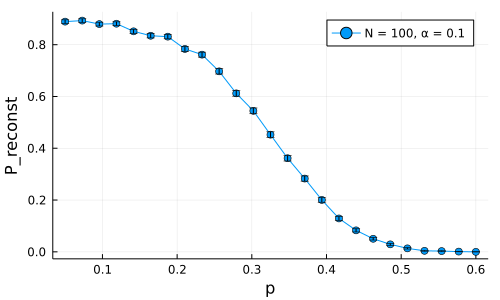

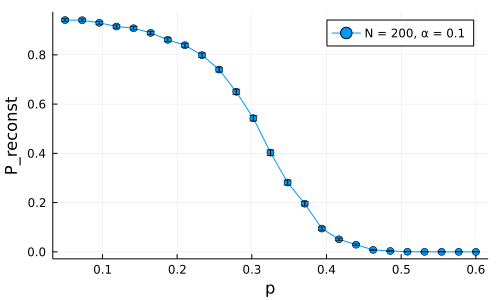

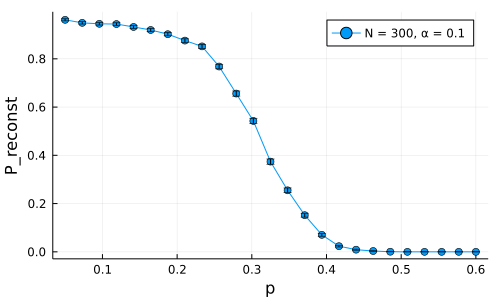

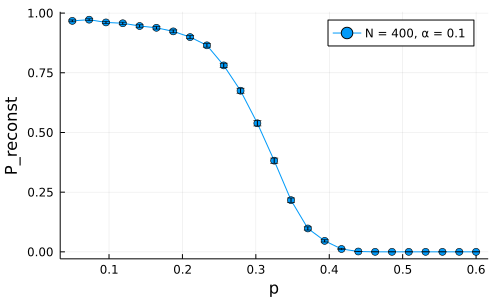

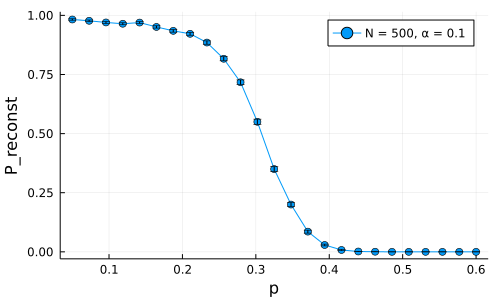

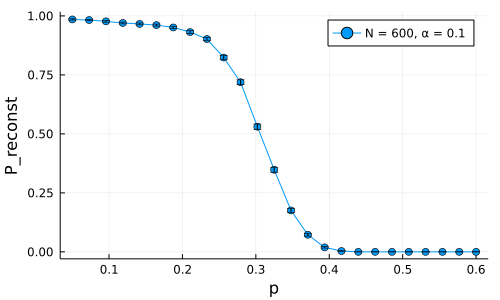

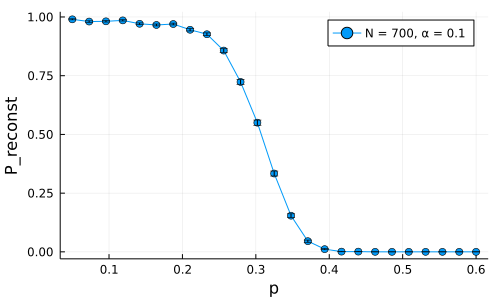

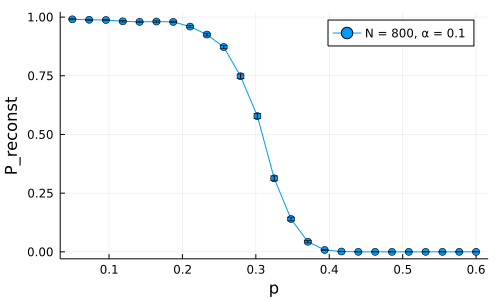

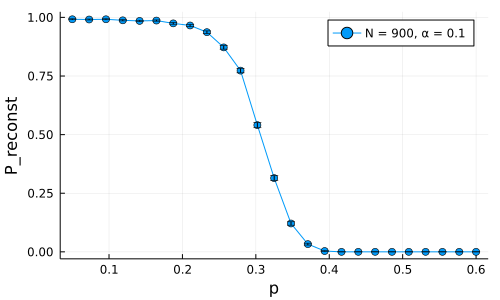

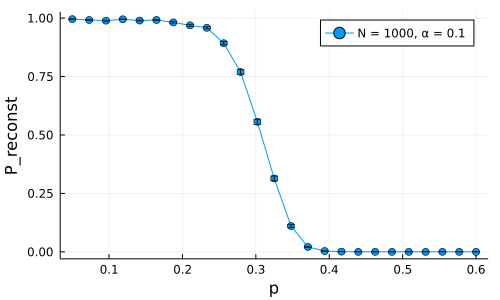

In [4]:
NN = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
pp = range( 0.05, 0.6, length = 25 )
α = 0.1
nsweeps = 100
β = 10^3
nsamples = 2000
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
          writedlm(io, [p e m])
    end
end

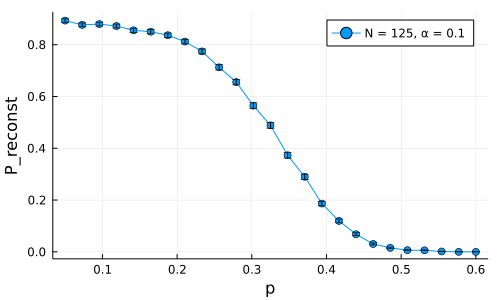

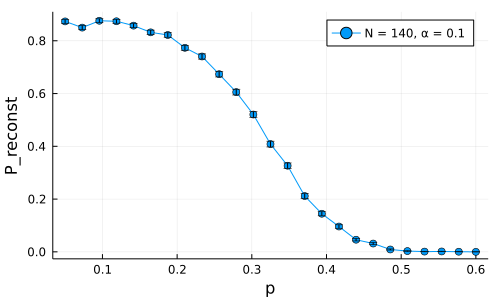

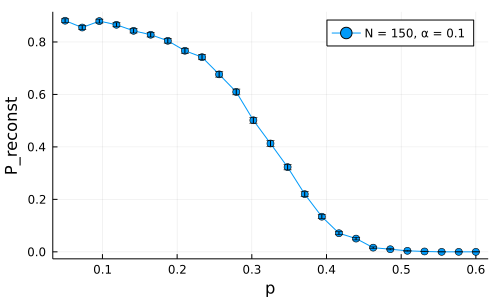

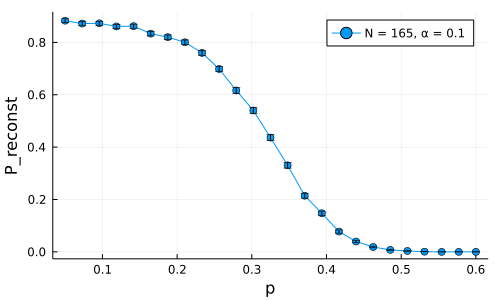

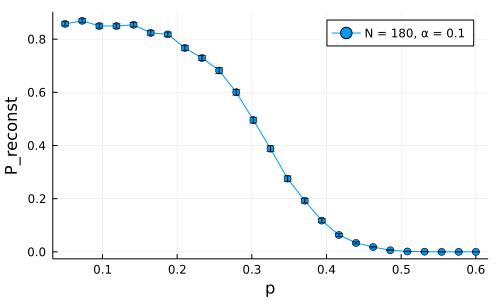

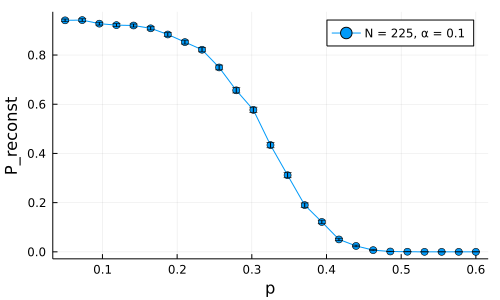

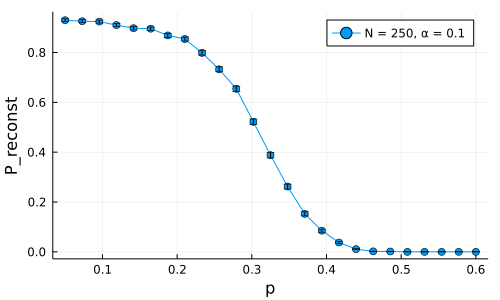

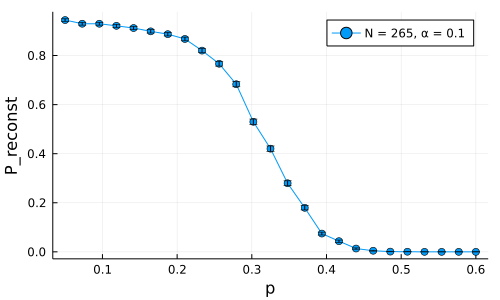

In [5]:
NN = [125, 140, 150, 165, 180, 225, 250, 265]
pp = range( 0.05, 0.6, length = 25 )
α = 0.1
nsweeps = 100
β = 10^3
nsamples = 2000
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
          writedlm(io, [p e m])
    end
end

### Load the data

In [62]:
PN_100 = readdlm("julia_data/alpha_01/probsN100pp.txt", '\t', Float64, '\n')[:, 1]
PN_150 = readdlm("julia_data/alpha_01/probsN150pp.txt", '\t', Float64, '\n')[:, 1]
PN_200 = readdlm("julia_data/alpha_01/probsN200pp.txt", '\t', Float64, '\n')[:, 1]

30-element Vector{Float64}:
 0.9243333333333333
 0.9263333333333333
 0.9053333333333333
 0.8916666666666667
 0.8553333333333333
 0.8156666666666667
 0.762
 0.674
 0.581
 0.4513333333333333
 0.325
 0.19266666666666668
 0.127
 ⋮
 0.0
 0.0003333333333333333
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

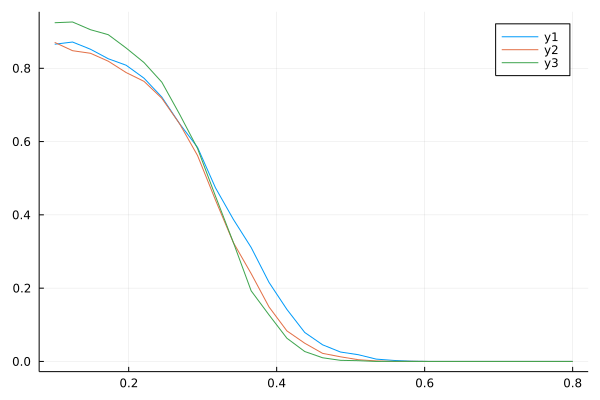

In [63]:
pp = range( 0.1, 0.8, length = 30 )
plot(pp, [PN_100, PN_150, PN_200])